In [1]:
# Import Required Libraries

import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import joblib

C:\Users\Roshen Perera\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load dataset form Hugging Face
print("Loading medical tanscriptions - dataset !")
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")
print(dataset)

#convert to the pandas dataframes - (training ,validations and testing )
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Testing Datasets

print("Test shape:", test_df.shape)
print("Train shape:", train_df.shape)
print("Validation shape:", validation_df.shape)


Loading medical tanscriptions - dataset !


Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 1724
    })
    validation: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 370
    })
    test: Dataset({
        features: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords'],
        num_rows: 370
    })
})
Test shape: (370, 5)
Train shape: (1724, 5)
Validation shape: (370, 5)


In [3]:
# Let's look at the first few rows of our data
print("First 5 rows of the dataset:")
print(train_df.head())

First 5 rows of the dataset:
                                         description  \
0  Pacemaker ICD interrogation.  Severe nonischem...   
1  Erythema of the right knee and leg, possible s...   
2  Left cardiac catheterization with selective ri...   
3  Patient with a history of coronary artery dise...   
4  Cardiac evaluation and treatment in a patient ...   

                                       transcription  \
0  PROCEDURE NOTE: , Pacemaker ICD interrogation....   
1  PREOPERATIVE DIAGNOSES: , Erythema of the righ...   
2  PREOPERATIVE DIAGNOSIS: , Post infarct angina....   
3  REASON FOR VISIT: , Acute kidney failure.,HIST...   
4  REASON FOR REFERRAL: , Cardiac evaluation and ...   

                                     sample_name           medical_specialty  \
0                        Pacemaker Interrogation  Cardiovascular / Pulmonary   
1                        Aspiration - Knee Joint                  Orthopedic   
2  Cardiac Cath & Selective Coronary Angiography  Cardiov

In [4]:
# Get some basic information about the dataset
print("\nDataset Information:")
train_df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1724 non-null   object
 1   transcription      1724 non-null   object
 2   sample_name        1724 non-null   object
 3   medical_specialty  1724 non-null   object
 4   keywords           1109 non-null   object
dtypes: object(5)
memory usage: 67.5+ KB


In [5]:

# Check columns and basic info
for df,name in [(train_df,'train'),(validation_df,'val'),(test_df,'test')]:
    print(name, df.columns.tolist())
    print(df[['description','transcription']].applymap(lambda x: len(str(x)) if pd.notna(x) else 0).agg(['mean','min','max']))

# Class distribution
print('\nClass distribution (train):')
display(train_df['medical_specialty'].value_counts())


train ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']
      description  transcription
mean   140.400232    3326.159513
min     14.000000      13.000000
max    491.000000   15216.000000
val ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']
      description  transcription
mean   134.291892    3393.613514
min     19.000000      23.000000
max    462.000000   11506.000000
test ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']
      description  transcription
mean   142.483784    3210.740541
min     20.000000      13.000000
max    491.000000   11301.000000

Class distribution (train):


C:\Users\Roshen Perera\AppData\Local\Temp\ipykernel_29292\1984950803.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[['description','transcription']].applymap(lambda x: len(str(x)) if pd.notna(x) else 0).agg(['mean','min','max']))
C:\Users\Roshen Perera\AppData\Local\Temp\ipykernel_29292\1984950803.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[['description','transcription']].applymap(lambda x: len(str(x)) if pd.notna(x) else 0).agg(['mean','min','max']))
C:\Users\Roshen Perera\AppData\Local\Temp\ipykernel_29292\1984950803.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[['description','transcription']].applymap(lambda x: len(str(x)) if pd.notna(x) else 0).agg(['mean','min','max']))


medical_specialty
Cardiovascular / Pulmonary    526
Orthopedic                    289
Neurology                     187
Gastroenterology              152
Obstetrics / Gynecology       126
Hematology - Oncology          86
Neurosurgery                   76
ENT - Otolaryngology           53
Pediatrics - Neonatal          51
Psychiatry / Psychology        49
Nephrology                     45
Ophthalmology                  45
Radiology                      39
Name: count, dtype: int64

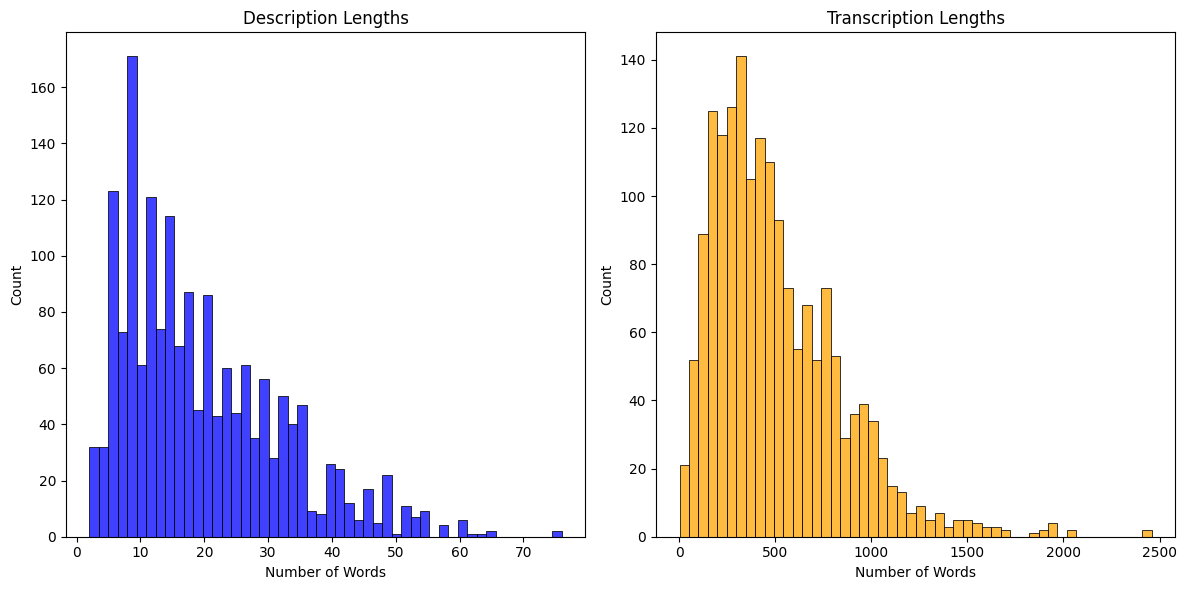

In [6]:
# Calculate word counts for both text fields
train_df['transcription_length'] = train_df['transcription'].str.split().str.len()
train_df['description_length'] = train_df['description'].str.split().str.len()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.histplot(train_df['description_length'], bins=50, color='blue')
plt.title("Description Lengths")
plt.xlabel("Number of Words")

plt.subplot(1,2,2)
sns.histplot(train_df['transcription_length'], bins=50, color='orange')
plt.title("Transcription Lengths")
plt.xlabel("Number of Words")

plt.tight_layout()
plt.show()


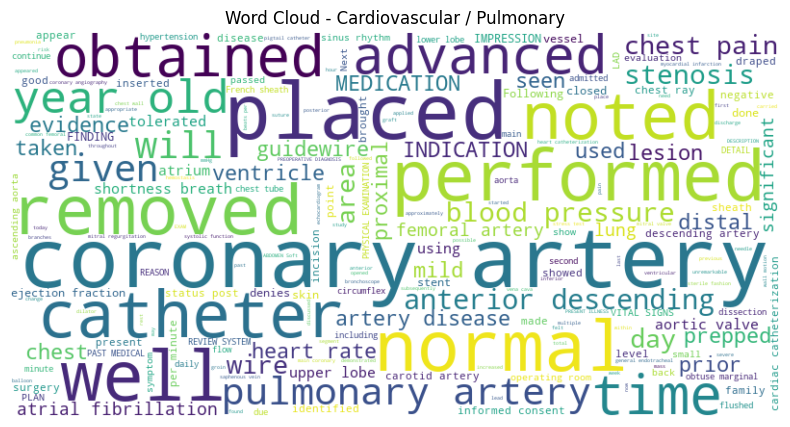

In [7]:
from wordcloud import WordCloud, STOPWORDS

# Add custom stopwords (to remove common non-medical words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["patient", "procedure", "history", "left", "right", "one", "two", "three"])  


specialty = "Cardiovascular / Pulmonary"
text = " ".join(train_df[train_df['medical_specialty'] == specialty]['transcription'].astype(str))

wc = WordCloud(width=800, height=400, background_color='white',
               stopwords=custom_stopwords,
               min_word_length=3,   # removes short meaningless words
               colormap='viridis').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud - {specialty}") 
plt.show()


C:\Users\Roshen Perera\AppData\Local\Temp\ipykernel_29292\3167719261.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df,


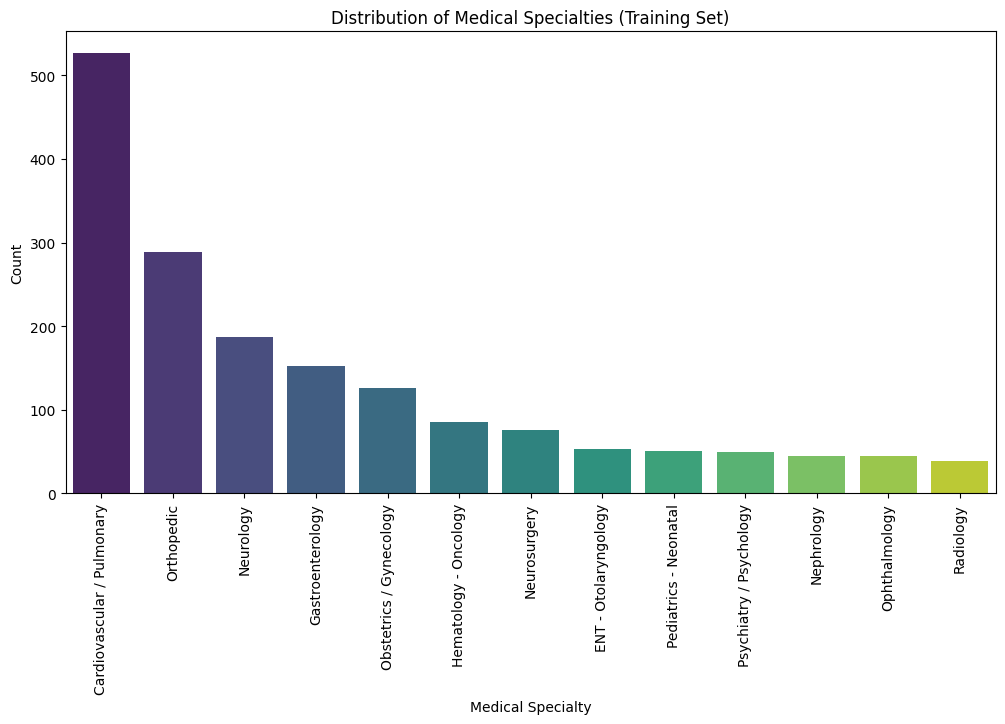

medical_specialty
Cardiovascular / Pulmonary    526
Orthopedic                    289
Neurology                     187
Gastroenterology              152
Obstetrics / Gynecology       126
Hematology - Oncology          86
Neurosurgery                   76
ENT - Otolaryngology           53
Pediatrics - Neonatal          51
Psychiatry / Psychology        49
Nephrology                     45
Ophthalmology                  45
Radiology                      39
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution in training set
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, 
              x="medical_specialty", 
              order=train_df['medical_specialty'].value_counts().index,
              palette="viridis")

plt.xticks(rotation=90)
plt.title("Distribution of Medical Specialties (Training Set)")
plt.xlabel("Medical Specialty")
plt.ylabel("Count")
plt.show()

# Print actual counts
print(train_df['medical_specialty'].value_counts())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',   # remove common words (the, and, etc.)
    lowercase=True,         # normalize by converting all words to lowercase
    max_features=5000,      # limit to top 5000 words/phrases
    ngram_range=(1,2)       # use unigrams and bigrams
)

# Fit on training set and transform
X_train_tfidf = tfidf.fit_transform(train_df['transcription'])
y_train = train_df['medical_specialty']

# Transform validation and test sets using the same fitted vectorizer
X_val_tfidf = tfidf.transform(validation_df['transcription'])
y_val = validation_df['medical_specialty']

X_test_tfidf = tfidf.transform(test_df['transcription'])
y_test = test_df['medical_specialty']

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Validation TF-IDF shape:", X_val_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (1724, 5000)
Validation TF-IDF shape: (370, 5000)
Test TF-IDF shape: (370, 5000)


In [ ]:

import os

# Create artifacts directory if it doesn't exist (relative path)
artifacts_dir = '../artifacts'
os.makedirs(artifacts_dir, exist_ok=True)

# Save the feature names
feature_names = tfidf.get_feature_names_out()
joblib.dump(feature_names, os.path.join(artifacts_dir, 'feature_names.joblib'))
print("Feature names saved successfully!")

# Save the fitted vectorizer
joblib.dump(tfidf, os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))
print("TF-IDF vectorizer saved successfully!")

# Save the vectorized data + metadata
joblib.dump({
    'X_train': X_train_tfidf,
    'X_val': X_val_tfidf,
    'X_test': X_test_tfidf,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': feature_names,
    'class_names': sorted(train_df['medical_specialty'].unique())
}, os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
print("Preprocessing assets saved successfully!")


Feature names saved successfully!
TF-IDF vectorizer saved successfully!
Preprocessing assets saved successfully!


: 